# 大課題 タイタニック生存予測 ランダムフォレスト

# データ取得
## データ読み込み

In [1]:
import pandas as pd
import numpy as np

df_train= pd.read_csv("./input/train.csv")
df_test=pd.read_csv("./input/test.csv")

 ### データ確認
 データの中身を確認していきます。特徴量は１２で、ところどころ、欠損値が見受けられます。

In [2]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


特徴量のうち、カテゴリカルが４個あります。
データ数は891。  
欠損値を持つ特徴量はAge 、Cabin、Embarkedの三つです。

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 前処理について記述せよ  

- 前処理とは何か  
機械学習の学習器でデータを使用するときに、学習器がデータをうまく扱うことができるように加工をすること。  

- なぜ前処理を行う必要があるのか  
常にデータがきれいに揃っていたり、学習器に対応した記述になっているわけではない現実があるため。  
また、前処理を行うことにより、分析の精度が大きく変わることがあるため。  
  
- 前処理は具体的に何を行うか(3つ以上記述せよ)  
①データを統一した型に変換  
②欠損値を埋めたり、除去する。  
③外れ値があれば除去する。  
④データのスケーリング。  
- 前述した具体的な前処理について、その前処理を行うと何を得ることができるか(記述したそれぞれの前処理例について記述せよ)  
①単位が異なると正しい分析が不可能だが、統一したデータ型に揃えることでデータを信頼して扱えるようになる。  
②欠損値があれば、学習器で必ずエラーが発生してしまうので、エラーを防ぐことができる。  
③外れ値を持ったままデータを学習器に入れて学習させた場合、過学習が起こりやすく、未知のデータに対しての精度が落ちるため外れ値を除去することで、予測の精度を高めることできる。  
④特徴量同士で、データの絶対値がことなる場合、スケーリングによって異なる特徴量同士でも比較できるように大きさを調整することで精度が上がる。  

# 2/前処理について記述せよ
前処理について記述せよの調査により、データを確認する際にどのような点を見るとよいか、3つ以上記述せよ。

①全ての特徴量のデータの中身が数値か文字列か、または数値でも単位が統一されてるのか。  
②欠損値があるか  
③散布図で外れ値がないか確認する。  
④特徴量同士の数値のスケールの乖離が大きいか。

# 前処理を行う

### 前処理１

In [5]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

df_train = transform_features(df_train)
df_test = transform_features(df_test)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


### 前処理２

In [6]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

df_train, df_test = encode_features(df_train, df_test)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


#  前処理の内容について記述せよ

以上のメソッドがそれぞれ何を行っているか記述せよ  
それぞれなぜそのようなことを行っているか記述せよ(それによって得られるメリットまで考察すること)　　

### simplify_ages  
データセットをbins内の年齢層ごとに、配列group_namesへのカテゴリカル化処理を行なっている。
年齢を束ねてカテゴリカルに区分することで、年齢層ごとに数値化し、棒グラフなどで可視化するのに便利にもなる。

 ### simplify_cabins  

欠損値を'N'に置き換え、その他は各文字列の最初のアルファベットに置き換える処理をしている。  
データが大文字の数種のアルファベットと異なる数値の組み合わせて入力されていると思われ、このままだと膨大な種類になってします。先頭のアルファベットで分類しデータ型をオブジェクト型に統一させて処理を行うことで

### simplify_fares
乗船チケット金額を５つのクラスに分ける関数を定義している。欠損値には'Unknown'でうめる。
生存率がチケットの金額にも関係していることが予想されるため、特徴量として数値化する前処理として有効である。

### format_name
 'Name'の前から１つ目のブロックを'Lname'に２つ目のブロックを'NamePrefix'という新しい特徴量をつくりそれぞれ格納している。  
'Lname'から、家族関係を集計が可能になり、生存率を考える上で有効な特徴量になってくる。また'NamePrefix'は、社会的な地位などの情報が取得でき、生存率の分析に有効になる。

### drop_features

'Ticket', 'Name', 'Embarked'の特徴量をデータセットから削除している。
すでに取得してきた特徴量から、'Ticket'は 'Fare'に, 'Name'は'Lname'に, 'Embarked'は現在すでにある特徴量で説明されていると考えられるので削除可能と判断できる。また特徴量を整理することで処理速度を軽減できる。」

### encode_features  
trainデータ、testデータを連結したあと、お互いの'Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix'のカテゴリカルデータをLabelEncoder()メソッドで、数値(ラベル)にエンコードして、先頭を表示している。  
すべての特徴量を数値化することで学習器に入力できる準備が整った。

# モデル選択について記述せよ

### 今回は、生存予測（分類）を行いますが、この分類について使用できそうな手法を4つ以上しらべて記述せよ。
 - 決定木分析
 - ランダムフォレスト
 - SVM(サポートベクターマシン)
 - ロジスティック回帰

### その手法の概要をそれぞれ記述せよ
- その手法の概要をそれぞれ記述せよ
- その手法の長所/短所をそれぞれ3つずつ、記述したすべての手法において記述せよ

### 決定木
#### 概要
教師あり学習の一つで定められたクラス分類に関する問題を扱う。具体的には「決定木」と呼ばれる樹木上のモデルを使って、上から順に条件分岐を作りデータセットを分類することで、その結果に与えた要因を分析し、その分類結果を利用して将来の予測を行う。
#### 長所

- 解釈が容易
- 前処理が少ない
- モデルの複雑さを制約する(過学習を防ぐ)パラメータは3つしかない

#### 短所  
- パラメータで過学習を抑制しようとしても過剰学習しやすく汎化性能が低い。
- あまり多くの特徴量を扱うのは難しい。  
- 分類性能が高い手法では無い

### ランダムフォレスト
#### 概要
決定木をたくさん作ってその結果を多数決（平均化）することで、決定木の過学習を平準化するアルゴリズム。このことをアンサンブル学習という。
#### 長所
- 多数決アンサンブル学習のため過学習が起こりにくい。
- 特徴量の標準化や正規化の必要がない。
- どの特徴量が重要かを数値化することが可能  

#### 短所  
- 木を深くしすぎると過学習を起こす。
- 複雑なデータではSVMなどの分類手法に比べて汎化性能が下がる。
- 説明変数のうち意味のある変数がノイズ変数よりも極端に少ない場合にはうまく働かない

### SVM(サポートベクターマシン)
#### 概要
教師あり機械学習方法であり、局所解収束の問題が無い長所がある。「マージン最大化」というアイデア等で汎化能力も高め、現在知られている方法としては、最も優秀なパターン識別能力を持つとされている。またカーネルトリックという手法で、線形分離不可能な場合でも適用可能になったことで応用範囲が格段に広がり、近年研究が盛んになっている。
#### 長所

- データの次元が大きくなっても識別精度がよい。
- 最適化すべきパラメータが少ない
- パラメータの算出が容易。  

#### 短所  
- 学習データが増えると計算量が膨大になる。
- 基本的に２クラス分類にしか使えない。
- 線形分離不可能な場合でも柔軟に対応できるが必ずしもよい識別器が構成されるとは限らない。

### ロジスティック回帰
#### 概要
２分類モデルを作るためアルゴリズム。分類に直線ではなくS字型の曲線を使用するためデータをグループに分けるのに適している。分類結果の値を予測するのではなく、目的変数が１になる確率を予測する。
#### 長所
- 高速で単純
- 線形分離可能なクラスに対して高い性能が発揮される。
- モデルの中身を数式として出力できる。  

#### 短所

- 非線形の問題はうまく学習できない。
- あまり関係のない説明変数を使用したり、データ数が少ないと、誤った結果を導くことがある
- 

#  モデル選択の基準
- モデルの精度
- データセットのデータ使用量の大きさによってトレーニング時間を考慮する必要性が生じてくる。
- モデルのパラメータの数
- データセットの特徴量の数


# モデル選択におけるデータ可視化

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

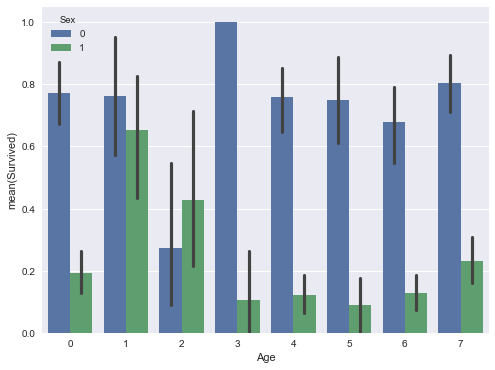

In [8]:
plt.figure(figsize=(8,6))
sns.barplot(x="Age", y="Survived", hue="Sex", data=df_train);

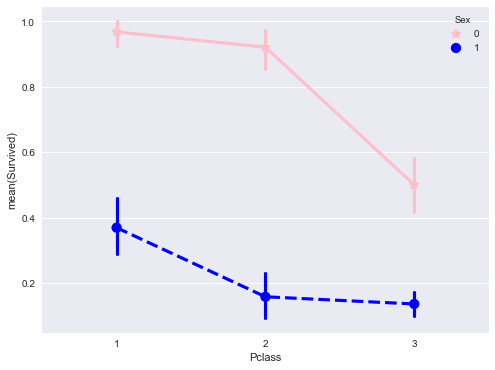

In [9]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=df_train,
              palette={1: "blue", 0: "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

 # データ可視化の結果について考察せよ
#### 上記の２つの可視化から分かったことについて考察せよ。

各年齢層で見ると、'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior'　まで圧倒的に女性の生存率が高いが、'Child'では男の子の方の生存率が高いことがわかる。
性別とPclassの図では、全体的に女性の生存率が高いが、男女ともPclass1が高く、２、３と率が下がっていることから、富裕層、社会的地位ある人たちの生存率が高いと推測できる。

#### 上記の考察結果から、モデル選択を考える場合、どのようなことが考えられるか

生存率に関わってくる大きな要素が、性別、チケットの金額、そして年齢層になると推測できので、分類問題に得意なモデルがいい。

# データセットの分割
それでは、テストデータの作成を行いましょう。学習データとテストデータの比は8:2とします。

In [10]:
from sklearn.model_selection import train_test_split

X = df_train.drop(['Survived', 'PassengerId'], axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666,)

# ランダムフォレストについて記述せよ  
今回は、ランダムフォレストという手法を使用します。  
以下の観点をすべて含めて記述しましょう。

### 決定木とはどのような手法か  
教師あり学習の一つで定められたクラス分類に関する問題を扱う。具体的には「決定木」と呼ばれる樹木上のモデルを使って、上から順に条件分岐を作りデータセットを分類することで、その結果に与えた要因を分析し、その分類結果を利用して将来の予測を行う。

### ランダムフォレストとはどのような手法か  
決定木をたくさん作ってその結果を多数決（平均化）することで、決定木の過学習を平準化するアルゴリズム。このことをアンサンブル学習という。

### ランダムフォレストの長所と短所をそれぞれ3つ以上挙げてください。
#### 長所 
- 多数決アンサンブル学習のため過学習が起こりにくい。
- 特徴量の標準化や正規化の必要がない。
- どの特徴量が重要かを数値化することが可能　　

#### 短所  

- 木を深くしすぎると過学習を起こす。
- 複雑なデータではSVMなどの分類手法に比べて汎化性能が下がる。
- 説明変数のうち意味のある変数がノイズ変数よりも極端に少ない場合にはうまく働かない


### 今回の目的からランダムフォレストの手法が適する理由を考察し、記述せよ  





# 学習

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=10,random_state=0,n_estimators=10, n_jobs=2)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# accuracyを求めよ
## 精度を高める
この課題では75%以上の精度が出ていた場合、合格とします。

In [12]:
from sklearn.metrics import (roc_curve, auc, accuracy_score)
pred=clf.predict(X_test)
accuracy_score(y_test,pred)

0.81564245810055869

# ハイパーパラメータについて
- ハイパーパラメーターとは何か  
モデルがデータセットで学習する前に人間があらかじめ設定しておかなければならないパラメータ。

- ランダムフォレストにおいてどのようなハイパーパラメーターがあるか4つ以上記述せよ  
　 　n_estimators、criterion、max_features、 max_depth
- 記述したハイパーパラメーターにおいて、それぞれどのような値が存在するか記述せよ（そのハイパーパラメーターを変化させるとどのようなことが起きるかも記述すること）  

   - n_estimators  
     整数を指定する。デフォルトの値は10。決定木の個数を指定する。個数を増やせば学習データの精度は上がるが過学習が起こる可能性がある。
   - criterion  
     文字列を指定し、デフォルトは mse(平均二乗誤差)で、その他に 　gini,entropyなどがある。決定木がデータを分割する基準とする指標を指定する。
     分割した結果どの程度情報が整理されたかを算出する方法を選択する。
   - max_features  
   整数，小数，文字列または None を指定できる。デフォルトは None。最適な分割をするために考慮する特徴量の数を指定する。整数を指定した場合，その個数，小数の場合全フィーチャーに対する割合個，auto を指定した場合，フィーチャー数のルート個，log2 を指定した場合，log2(フィーチャー数) 個で基本は None を使うべき。値が大きいと似たような決定木が増え、小さいと決定木がばらけるがデータに適合できにくくなる。
   - max_depth  
     整数または None を指定できる。決定木の深さの最大値になる。この値を上げることでモデルの精度も上がるが過学習も発生する。


 # チューニング

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

scores= []
params=[]
for n_estimators in [4, 6, 9]:
    for max_feature in ['log2', 'sqrt','auto']:
        for criterion in ['entropy', 'gini']:
            for max_depth in [2, 3, 5, 10]:
                for min_samples_split in [2, 3, 5]:     
                    for min_samples_leaf in [1,5,8]:
                        clf = RandomForestClassifier(n_estimators=n_estimators,\
                                                                           max_features=max_feature,\
                                                                           criterion= criterion,\
                                                                           max_depth=max_depth,\
                                                                            min_samples_split= min_samples_split,\
                                                                            min_samples_leaf= min_samples_leaf)
                        #clfにfit
                        clf.fit(X_train, y_train.as_matrix().reshape(-1,))
                        #predict
                        y_pred = clf.predict(X_test) 
                        # スコアさんしゅつ
                        score = accuracy_score(y_test, y_pred)
                        # スコアのappend?
                        scores.append(score)
                        params.append(list([n_estimators,\
                                                            max_feature,\
                                                            criterion,\
                                                            max_depth,\
                                                            min_samples_split,\
                                                            min_samples_leaf]))

In [14]:
scores=pd.DataFrame(scores)
scores.columns=['score']

In [15]:
params=pd.DataFrame(params)
params.columns=['n_estimators','max_features','criterion','max_depth',
                                'min_samples_split','min_samples_leaf']

###  ベストスコアと最適化されたパラメータ

In [16]:
scores.join(params).max()

score                0.832402
n_estimators                9
max_features             sqrt
criterion                gini
max_depth                  10
min_samples_split           5
min_samples_leaf            8
dtype: object

#  検証について記述せよ

### 検証は何か  
機械学習のモデルが未知のデータに対してどの程度正しく予測できるのかという汎化性能を評価すること。

### なぜ検証を行う必要があるのか(Accuracyだけではダメな理由も含めること)  
学習モデルの汎用性を評価し、より汎用性を高めるための改善に必要になる。
例えば二値分類に関してモデルの検証を行う場合の手法に、正解率（accuracy）、recall(再現率)、適合率（precision）,F値などがある。病気診断を考える場合、病気でありながら放置する誤診発生をリスクを減らすことが重要になる。その場合にRecallが適切な評価方法になる。  
一方、スパムメール判定モデルの精度を評価したい場合、スパムである、ないと実際に分類した結果がどの程度正解かで精度が変わるので、Accuracy(正解率)が適切な評価方法になる。このようにモデルを使う目的などで評価方法が変わってくるため複数の評価方法が必要になる。


### 主な検証方法について2つ以上記述せよ  

 - 正解率 Accuracy  
２値分類でモデル評価を行う際に、予測に対して答えがどのくらい合っていたかを数値であらわした指標。

 - ホールドアウト法  
元のデータをトレーニングデータとテストデータに分割し、トレーニングデータセットはモデルのトレーニングに使用され、テストデータセットはモデルの性能を評価するために使用する。デメリットはトレーニングデータセットはテストデータの分け方によって性能評価がかなり変わってしまう。


#  KFoldについて記述せよ

データ数が少ないときに、有効なモデルを評価する手法。  
データをK個に分割しそのうち１つをテストとし、残るK-1個のデータを学習用テータとする。この分割はランダム。そして、データ分割が完了したら、実際にK-1個のデータセットで学習を行い、1つに分割されたテストデータでテストを行う。  
 Kの値は大きければ大きいほど、正確にモデルを評価でき、最大値はサンプル数で「K= サンプル数」とした場合が最も正確な評価だと言える。
この学習、テストの作業を分割されたK個のそれぞれのデータの組み合わせに対してK回繰り返し、検証結果は、最後に各回で導き出した精度を平均化させる。

# KFoldを実施する

### accuracyをスコアに設定し５個に分割して実施

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

scoring = 'accuracy'
kfold = KFold(n_splits=5, random_state=42)
clf = RandomForestClassifier(criterion='gini', max_depth=10,
                                                    max_features= 'sqrt', min_samples_leaf = 5,
                                                    min_samples_split=8 ,n_estimators=9)
#result = clf.fit(X_train,y_train, cv = , scoring = "accuracy")
scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=kfold)

# Kfoldの結果を確認する

K分割のうちのテストデータで５回検証したスコアは以下の通りで、ほぼ近い値が出ていることが確認できるので、モデルの精度として信頼できる。

In [18]:
scores['test_score']

array([ 0.81818182,  0.88111888,  0.79577465,  0.83098592,  0.81690141])

最終的にモデルの予測値とテストデータでaccuracyの値を確認。

In [19]:
from sklearn.metrics import accuracy_score
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
accuracy_score(y_test, y_pred)

0.79329608938547491

# どの特徴量が重要であったかを調査する

重要な特徴量を左から順に棒グラフで表示する。

1   Sex   0.375730365535
2   NamePrefix   0.12876746106
3   Cabin   0.114465414918
4   Lname   0.104810786054
5   Pclass   0.102555915745
6   SibSp   0.0717867825025
7   Fare   0.0472497066074
8   Age   0.032075885077
9   Parch   0.0225576825015


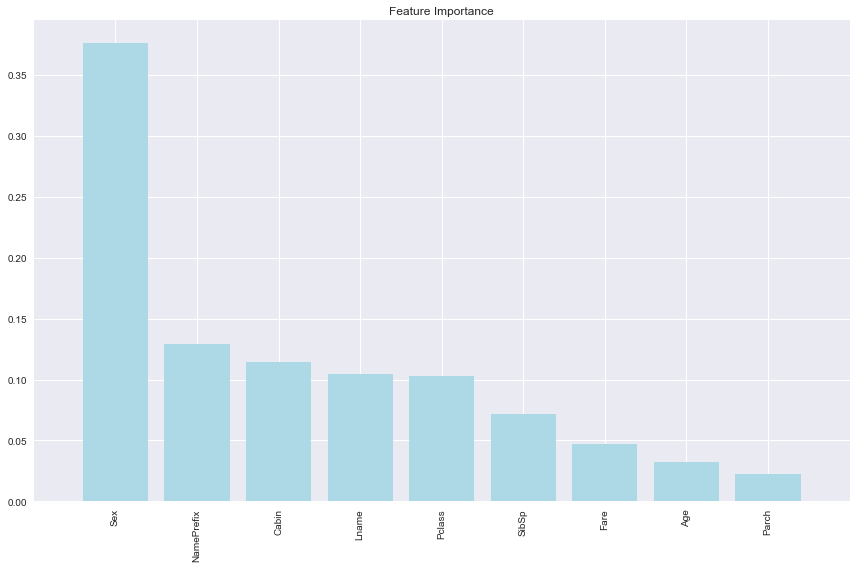

In [20]:
feature=clf.feature_importances_
#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.ix[:, 'number']

#特徴量の名前
label = X.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))
plt.figure(figsize=(12,8))
plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()